Discretized Data

In [1]:
import numpy as np

l = 4
m = 100
a = np.linspace(-2 * np.pi, 2 * np.pi, m)
b = np.sin(a)


Gaussian Sum Model

In [2]:
def phi(x, t, l=4):
    result = 0
    for i in range(l):
        alpha = x[3*i]
        mu = x[3*i + 1]
        sigma = x[3*i + 2]
        result += alpha * np.exp(-((t - mu)**2) / (2 * sigma**2))
    return result


Objective

In [3]:
def objective(x, a, b):
    return 0.5 * np.sum((np.array([phi(x, aj) for aj in a]) - b)**2)

def residuals(x, a, b):
    return np.array([phi(x, aj) - bj for aj, bj in zip(a, b)])


Line Search (Backtracking)

In [4]:
def backtracking(f, grad, x, p, alpha=1.0, rho=0.5, c=1e-4):
    fx = f(x)
    grad_fx = grad(x)
    while f(x + alpha * p) > fx + c * alpha * np.dot(grad_fx, p):
        alpha *= rho
    return alpha


Gradient (via finite differences or autodiff)

In [5]:
from scipy.optimize import approx_fprime

def gradient(f, x):
    epsilon = np.sqrt(np.finfo(float).eps)
    return approx_fprime(x, f, epsilon)


Quasi-Newton Methods

BFGS

In [6]:
def bfgs(f, x0, a, b, tol=1e-6, max_iter=100):
    x = x0.copy()
    H = np.eye(len(x))
    history = [x0.copy()]

    f_wrapped = lambda x_: f(x_, a, b)
    grad_wrapped = lambda x_: gradient(f_wrapped, x_)

    for i in range(max_iter):
        grad = grad_wrapped(x)
        if np.linalg.norm(grad) < tol:
            break
        p = -H @ grad
        alpha = backtracking(f_wrapped, grad_wrapped, x, p)
        s = alpha * p
        x_new = x + s
        y = grad_wrapped(x_new) - grad
        rho = 1.0 / (y @ s)
        H = (np.eye(len(x)) - rho * np.outer(s, y)) @ H @ (np.eye(len(x)) - rho * np.outer(y, s)) + rho * np.outer(s, s)
        x = x_new
        history.append(x.copy())
    return x, history

DFP

In [7]:
def dfp(f, grad_f, x0, a, b, tol=1e-6, max_iter=100):
    x = x0.copy()
    n = len(x)
    H = np.eye(n)
    history = [x0.copy()]
    for _ in range(max_iter):
        grad = grad_f(lambda x_: objective(x_, a, b), x)
        if np.linalg.norm(grad) < tol:
            break
        p = -H @ grad
        f_wrapped = lambda x_: objective(x_, a, b)
        grad_wrapped = lambda x_: grad_f(f_wrapped, x_)
        alpha = backtracking(f_wrapped, grad_wrapped, x, p)
        s = alpha * p
        x_new = x + s
        y = grad_f(lambda x_: objective(x_, a, b), x_new) - grad
        
        ys = y @ s
        if abs(ys) < 1e-12:
            print("Warning: Division by near-zero detected in rho computation (y @ s ≈ 0). Skipping update.")
            # Optionally break or continue here if you want to stop or skip update
            break
        
        rho = 1.0 / ys
        Hy = H @ y
        
        # Instead of checking Hy == 0 (vector), check its norm to avoid division by zero
        Hy_norm = np.linalg.norm(Hy)
        if Hy_norm < 1e-12:
            print("Warning: Hy vector norm is near zero, skipping Hessian update to avoid division by zero.")
            history.append(x_new.copy())
            x = x_new
            continue
        
        denom = y @ Hy
        if abs(denom) < 1e-12:
            print("Warning: Division by near-zero detected in Hessian update denominator (y @ Hy ≈ 0). Skipping update.")
            history.append(x_new.copy())
            x = x_new
            continue
        
        H = H + np.outer(s, s) / ys - np.outer(Hy, Hy) / denom
        x = x_new
        history.append(x.copy())
    return x, history


SR1 (Trust Region Framework)

In [8]:
def sr1_trust_region(f, grad_f, x0, a, b, delta=1.0, tol=1e-6, max_iter=100):
    x = x0.copy()
    n = len(x)
    B = np.eye(n)
    history = [x0.copy()]
    for _ in range(max_iter):
        g = grad_f(lambda x_: objective(x_, a, b), x)
        if np.linalg.norm(g) < tol:
            break
        # Trust-region step (Cauchy point or truncated CG)
        p = -np.linalg.solve(B + 1e-6*np.eye(n), g)
        if np.linalg.norm(p) > delta:
            p = p * delta / np.linalg.norm(p)
        s = p
        x_new = x + s
        y = grad_f(lambda x_: objective(x_, a, b), x_new) - g
        Bs = B @ s
        diff = y - Bs
        denom = diff @ s
        if abs(denom) > 1e-8:
            B += np.outer(diff, diff) / denom
        x = x_new
        history.append(x.copy())
    return x, history


Identify x*

In [9]:
import matplotlib.pyplot as plt

np.random.seed(42)

x0 = np.random.rand(12)
x_opt, _ = bfgs(objective, x0, a, b)
x_star = x_opt


Plot ϕ(x*, t) vs sin(t)

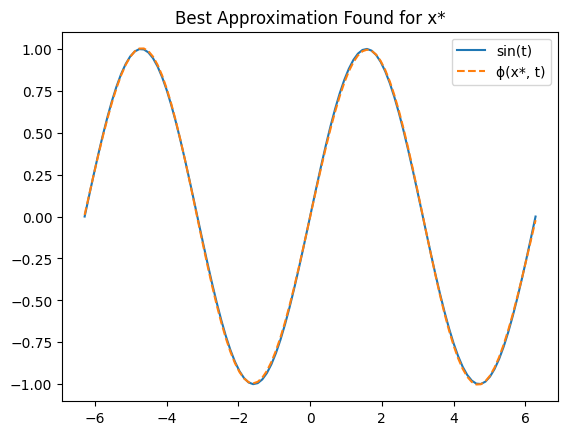

In [10]:
plt.plot(a, b, label="sin(t)")
plt.plot(a, [phi(x_star, aj) for aj in a],'--', label="ϕ(x*, t)")
plt.legend()
plt.title("Best Approximation Found for x*")
plt.show()


evaulate_runs from Diego

In [11]:
import time

np.random.seed(42)

def evaluate_runs(objective, x_star, method, method_name, num_runs=5, scales=[0.5, 0.75, 1.0, 1.5, 2.0]):
    for i, scale in enumerate(scales[:num_runs]):
        print(f"\n--- Run {i + 1} (scale = {scale}) ---")
        x0 = np.random.randn(3 * l) * scale
        start_time = time.time()
        x_final, history = method(x0)
        end_time = time.time()
        runtime = end_time - start_time

        distance = np.linalg.norm(x_final - x_star)
        k = len(history) - 2
        if k < 0:
            print("Insufficient iterations for convergence analysis.")
            continue

        xk = history[k]
        xk1 = history[k + 1]
        lk = np.linalg.norm(xk1 - x_star) / np.linalg.norm(xk - x_star)
        qk = np.linalg.norm(xk1 - x_star) / (np.linalg.norm(xk - x_star) ** 2)

        print(f"Stopping criterion: ||g|| < 1e-6 or max_iter = 100")
        print(f"Final iterate x̄:\n{x_final}")
        print(f"Distance to x*: {distance:.6f}")
        print(f"ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = {lk:.6f}")
        print(f"qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = {qk:.6f}")
        print(f"Runtime: {runtime:.4f} seconds")

        # Plotting result
        plt.figure()
        plt.plot(a, b, label="sin(t)")
        plt.plot(a, phi(x_final, a), '--', label="phi(x̄; t)")
        plt.title(f"Run {i + 1}: phi(x̄; t) vs sin(t) ({method_name})")
        plt.xlabel("t")
        plt.ylabel("Function value")
        plt.legend()
        plt.show()


BFGS

--- Run 1 (scale = 0.5) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-1.08087692 -2.43884726 -0.90580568 -6.61896721  4.54789333  2.35306505
  5.70135931  4.02269275  4.6624169  -3.32644361 -0.74400247 -1.46631788]
Distance to x*: 13.175773
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.008635
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.077213
Runtime: 3.2498 seconds


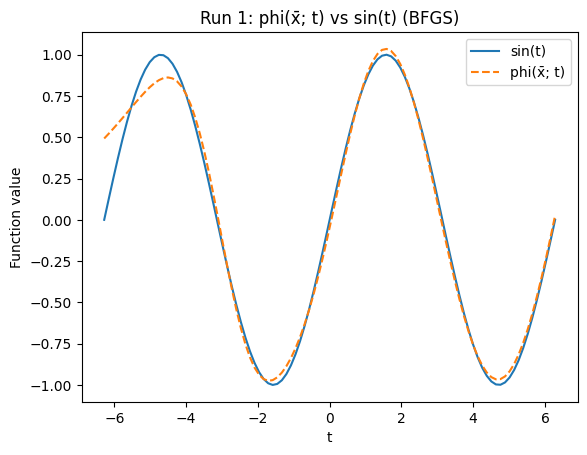


--- Run 2 (scale = 0.75) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-0.94108205 -1.25549646 -0.64931478  0.94108215  1.25549663  0.64931486
 -0.52611864 -2.25261086  0.40855513  0.52611841  2.25261097 -0.40855506]
Distance to x*: 5.205394
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.000000
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.192108
Runtime: 1.9939 seconds


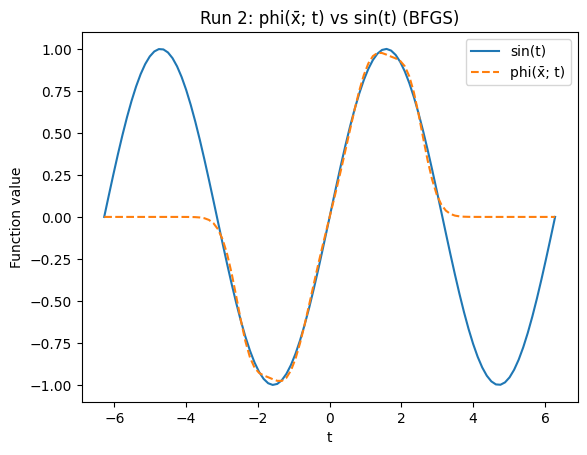


--- Run 3 (scale = 1.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-15.31700109  -3.19956228   1.60943067 -16.39984055  -1.15207041
   1.59631911  -5.12070117 -19.859996    13.19058289  27.20524084
  -2.24998905   2.24166708]
Distance to x*: 43.367214
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 0.998854
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.023006
Runtime: 3.1850 seconds


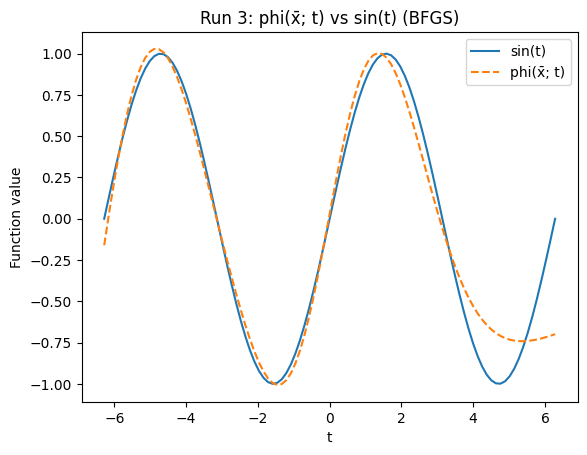


--- Run 4 (scale = 1.5) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 0.89017328 -5.01289713 -0.64993703  8.7286056   1.49971979  1.72310819
 -7.66697905  1.473488   -2.12260517  0.73681289 -3.7933164   0.69346254]
Distance to x*: 13.790752
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.008206
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.073707
Runtime: 3.1941 seconds


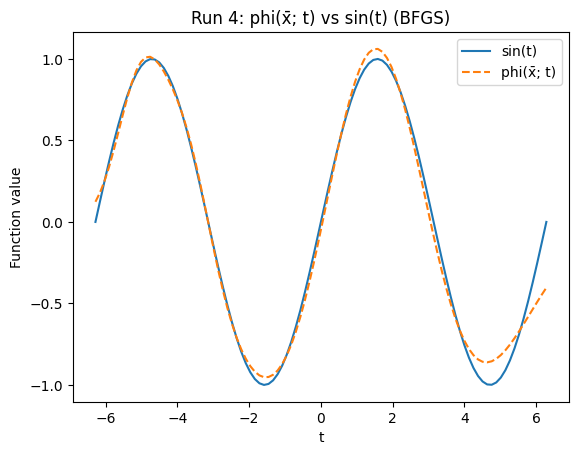


--- Run 5 (scale = 2.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[  9.12942179  -4.53362214   2.29275993 -10.5100487   -2.62512923
   4.27976928  10.79368139   2.53465785  -3.47808585  -7.56989804
   4.32956708   2.08093957]
Distance to x*: 21.915950
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.011843
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.046716
Runtime: 3.1972 seconds


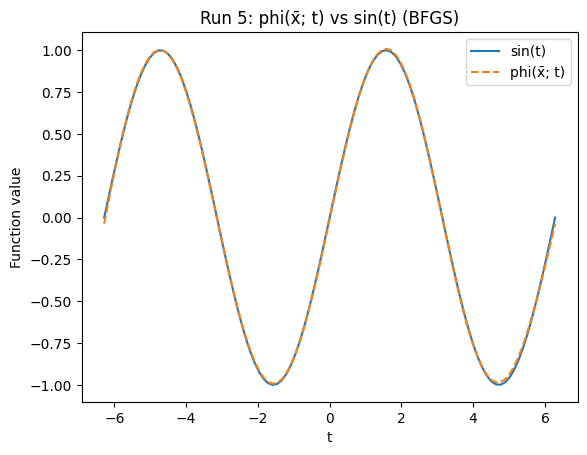

In [12]:
print("BFGS")
bfgs_method = lambda x0: bfgs(objective, x0, a, b)
evaluate_runs(objective, x0, bfgs_method, "BFGS")

DFP

--- Run 1 (scale = 0.5) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-1.07807187e+00 -1.52527702e+00  7.56714122e-01  5.47571892e-01
  2.24661194e+00  4.11244923e-01  1.44941156e+00  6.95135820e-01
  8.87896610e-04  9.40959937e-01  1.24399449e+00 -6.37039850e-01]
Distance to x*: 4.374717
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.000000
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.228586
Runtime: 2.0782 seconds


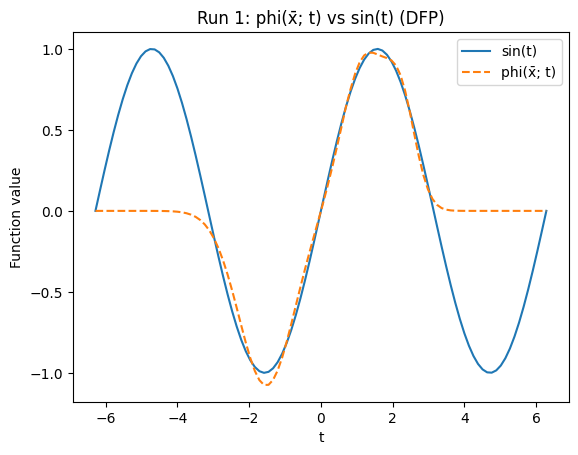


--- Run 2 (scale = 0.75) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-1.16066599  4.70246541 -0.81910248 -1.60381293  3.01961579  0.93232383
 -1.09007298 -1.46229447  0.79846582  1.99863098  2.51554154 -1.25232151]
Distance to x*: 7.218019
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.000643
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.138720
Runtime: 3.1931 seconds


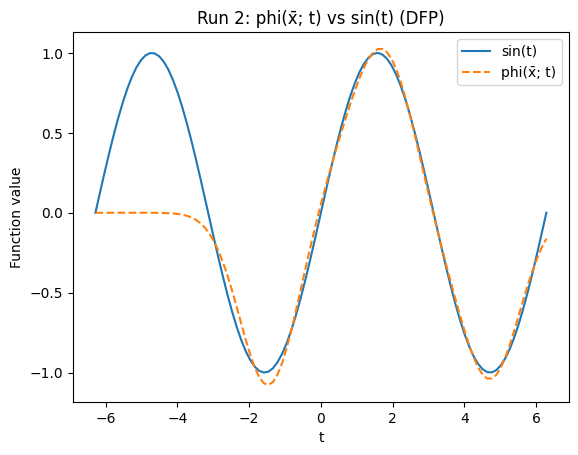


--- Run 3 (scale = 1.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-1.02554504 -1.62967917  0.70170692 -0.06417027 -0.1665051   0.44777504
  1.08075901  1.48499818 -0.79288011 -0.13558777 -0.64138481 -0.75894074]
Distance to x*: 4.093776
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 0.996106
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.242375
Runtime: 0.5208 seconds


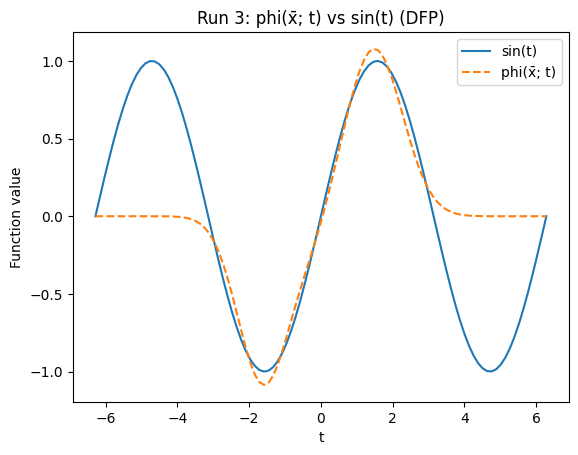


--- Run 4 (scale = 1.5) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 4.44180416e-01  3.91596447e-01  7.63341407e-03 -1.04361861e+01
 -3.19642862e-01  2.40981820e+00  8.20421694e+00  7.79565291e-01
 -1.91222459e+00  4.40014722e+00 -2.48507821e+00  2.42648994e+00]
Distance to x*: 14.920831
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.006463
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.067890
Runtime: 3.2800 seconds


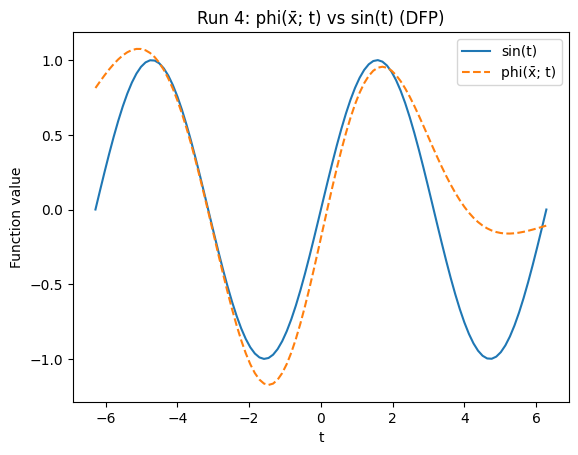


--- Run 5 (scale = 2.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-6.98063882  1.66077212 -2.5250378   0.22638083  3.80561669 -1.12330503
  1.00602392  4.76908146 30.09971921  6.99639756  1.59805275 -1.70324503]
Distance to x*: 31.871335
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.003897
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.031621
Runtime: 3.1991 seconds


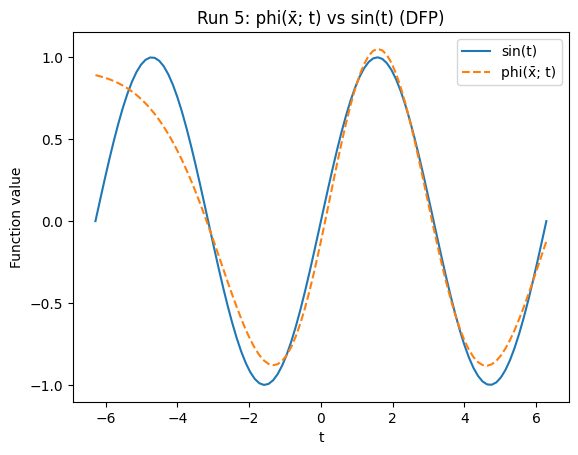

In [13]:
print("DFP")
dfp_method = lambda x0: dfp(objective, gradient, x0, a, b)
evaluate_runs(objective, x0, dfp_method, "DFP")

SR1

--- Run 1 (scale = 0.5) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 1.09181006  1.55677171  0.71568529 -1.0686773  -1.68068123  0.67490484
 -0.36799629 -0.61544192 -0.21970167 -0.00350084 -2.38434107  0.65643225]
Distance to x*: 4.091887
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.002692
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.245704
Runtime: 2.0340 seconds


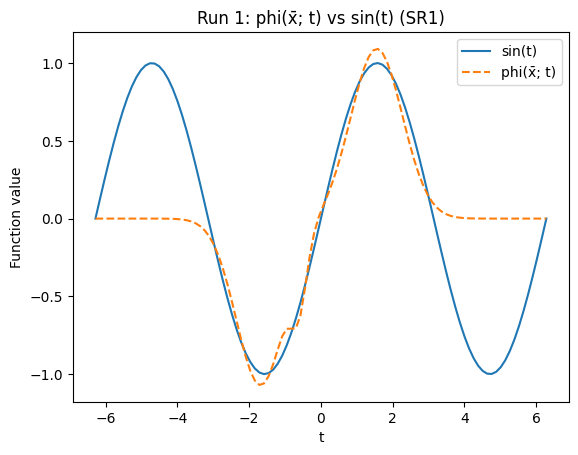


--- Run 2 (scale = 0.75) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-0.78112433 -0.975422   -0.66882367  0.94019842  1.79554052  0.62039742
  0.45405098  0.67318307 -0.68213173 -0.71571619 -2.05413406 -0.5080623 ]
Distance to x*: 4.514975
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.026155
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.233223
Runtime: 2.0378 seconds


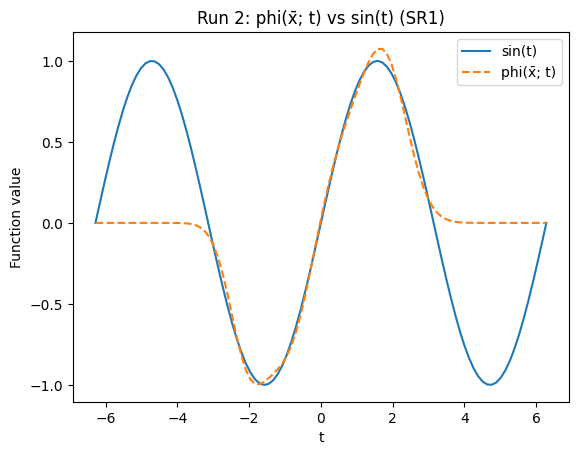


--- Run 3 (scale = 1.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 0.52610377  2.25260918 -0.40855136 -0.5261127  -2.25261866 -0.4085499
  0.94108271  1.25550337 -0.64932356 -0.94108376 -1.25549981 -0.64932105]
Distance to x*: 4.457463
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.000000
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.224343
Runtime: 2.0291 seconds


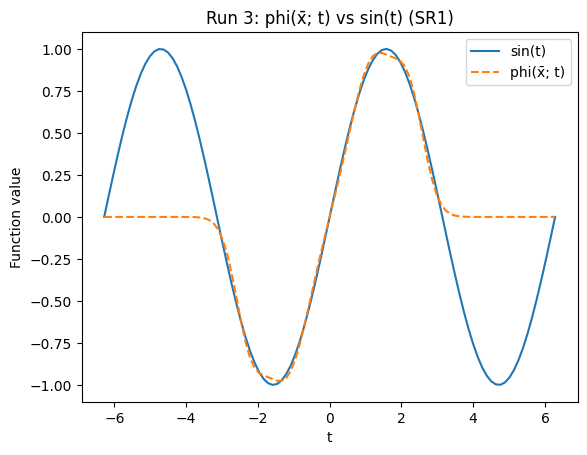


--- Run 4 (scale = 1.5) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 0.72470733  0.98618424  0.02002942 -0.47290401 -6.77560621  0.52351621
 -3.65302    -1.77861737  1.30657417  2.43086134 -1.96717231  2.28173859]
Distance to x*: 8.936805
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 0.942776
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.099457
Runtime: 2.0902 seconds


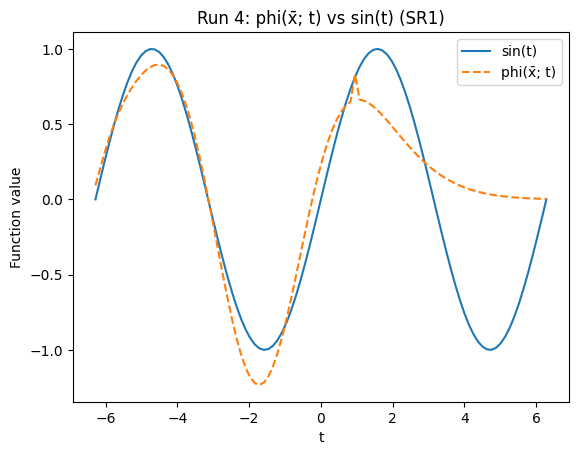


--- Run 5 (scale = 2.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 7.86570781e-01 -7.55141772e-01 -1.73442299e-02 -1.44012994e+00
 -1.59095559e+00  8.46312170e-01  3.06247970e-02 -2.66724770e+00
  8.60177624e+00  5.69509326e-01 -2.22814644e+01  1.84643603e+01]
Distance to x*: 29.854298
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.034099
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.035819
Runtime: 2.0566 seconds


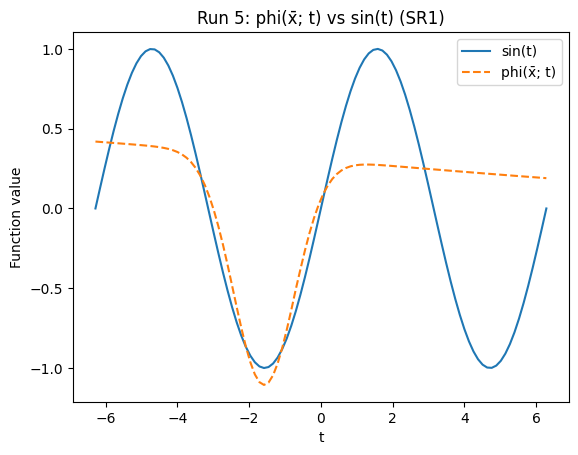

In [14]:
print("SR1")
sr1_method = lambda x0: sr1_trust_region(objective, gradient, x0, a, b)
evaluate_runs(objective, x0, sr1_method, "SR1")

Newton method

In [15]:
from scipy.optimize import approx_fprime
import numpy as np
import time

def jacobian(x, a, epsilon=1e-6):
    n = len(x)
    m = len(a)
    J = np.zeros((m, n))
    for i in range(n):
        x1 = x.copy()
        x1[i] += epsilon
        x2 = x.copy()
        x2[i] -= epsilon
        f1 = np.array([phi(x1, t) for t in a])
        f2 = np.array([phi(x2, t) for t in a])
        J[:, i] = (f1 - f2) / (2 * epsilon)
    return J

def backtracking(f, grad, x, p, alpha=1.0, rho=0.5, c=1e-4):
    fx = f(x)
    grad_fx = grad(x)
    while f(x + alpha * p) > fx + c * alpha * np.dot(grad_fx, p):
        alpha *= rho
    return alpha

def newton(objective, x0, a, b, max_iter=100, tol=1e-6, verbose=False):
    x = x0.copy()
    history = [x.copy()]

    for k in range(max_iter):
        # Compute residual and Jacobian
        r = residuals(x, a, b)
        J = jacobian(x, a)

        # Gradient and Gauss-Newton Hessian
        g = J.T @ r
        H = J.T @ J  # Gauss-Newton approximation

        grad_norm = np.linalg.norm(g)
        if verbose:
            print(f"Iter {k}: ||grad|| = {grad_norm:.2e}")

        # Stopping criterion
        if grad_norm < tol:
            if verbose:
                print(f"Converged at iteration {k}")
            break

        # Check conditioning
        cond = np.linalg.cond(H)
        if cond > 1e12:
            print(f"Hessian ill-conditioned at iteration {k} (cond = {cond:.2e}).")
            break

        try:
            # Check positive definiteness
            np.linalg.cholesky(H)
        except np.linalg.LinAlgError:
            print(f"Hessian not positive definite at iteration {k}.")
            break

        try:
            p = -np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            print(f"Hessian not invertible at iteration {k}.")
            break

        # Define objective and grad for backtracking
        def obj(x_):
            return objective(x_, a, b)

        def grad_f(x_):
            r_ = residuals(x_, a, b)
            J_ = jacobian(x_, a)
            return J_.T @ r_

        # Line search (optional in Newton, but keeps step safe)
        alpha = backtracking(obj, grad_f, x, p)

        x += alpha * p
        history.append(x.copy())

    return x, history


Newton

--- Run 1 (scale = 0.5) ---
Hessian ill-conditioned at iteration 0 (cond = 8.93e+12).
Insufficient iterations for convergence analysis.

--- Run 2 (scale = 0.75) ---
Hessian ill-conditioned at iteration 1 (cond = 6.39e+19).
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 0.05199432 -0.94082721  0.11203907  0.21939596 -0.65996929  0.10879489
  0.16766426 -0.7674556   0.01024529  0.4224305   0.82223695  0.79718154]
Distance to x*: 2.943157
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.006390
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.344127
Runtime: 0.0649 seconds


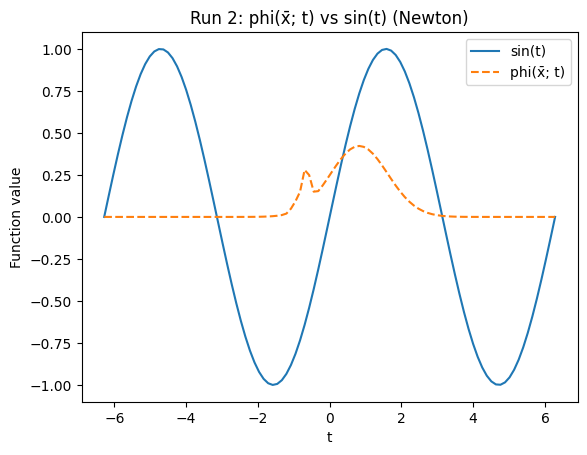


--- Run 3 (scale = 1.0) ---
Hessian ill-conditioned at iteration 6 (cond = 1.50e+19).
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[  -6.92212454 -331.7053899   132.07910069    1.03638347 -259.81576532
   39.16837474    0.93891004    2.35175853    0.77346463    1.11604143
    0.79897714   -0.68516404]
Distance to x*: 443.936254
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 32.866034
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 2.433179
Runtime: 0.2724 seconds


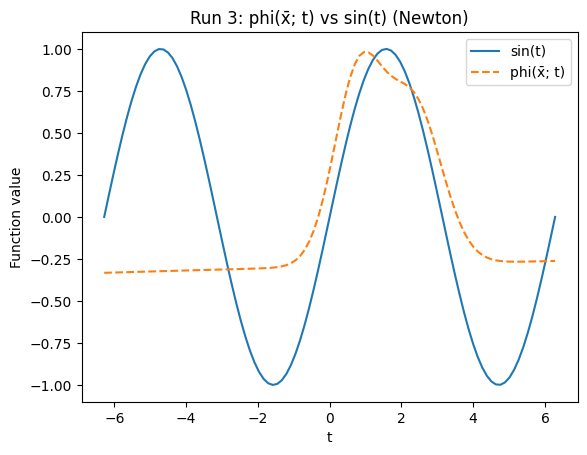


--- Run 4 (scale = 1.5) ---
Hessian ill-conditioned at iteration 2 (cond = inf).
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ -0.83985651  -0.35717502  -0.7547537   -0.51320247 128.65247907
  72.99372216   0.55729052  -2.39629345  -0.67487826  -0.18743342
 -11.44183049   0.14421372]
Distance to x*: 148.218415
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 3.998365
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.107861
Runtime: 0.1023 seconds


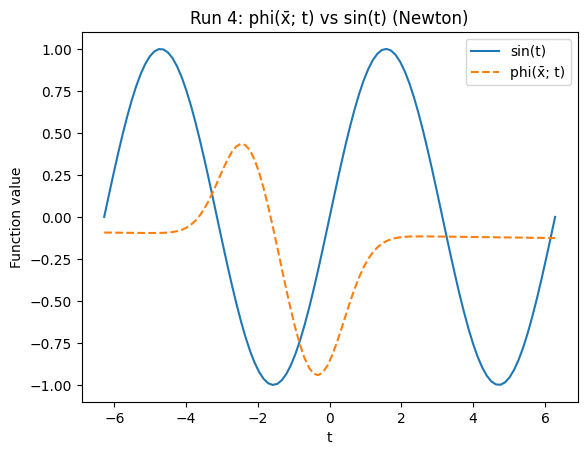


--- Run 5 (scale = 2.0) ---
Hessian ill-conditioned at iteration 7 (cond = 4.56e+20).
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-8.12869065e-01  2.48346731e+00 -1.09490910e+00 -8.01130181e+02
  2.17729196e+02  5.52396441e+01  9.10480806e+02 -1.39102118e+03
 -2.74106057e+02 -2.65343207e+02 -5.55330988e+01 -1.12976797e+01]
Distance to x*: 1899.697998
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 190.194844
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 19.042015
Runtime: 0.3270 seconds


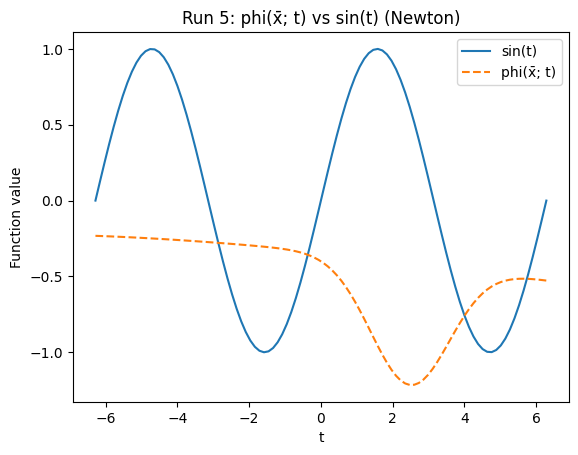

In [16]:
print("Newton")
newton_method = lambda x0: newton(objective, x0, a, b)
evaluate_runs(objective, x0, newton_method, "Newton")

In [17]:
def classify_convergence(lk, qk, tol=1e-2):
    if qk < tol:
        return "Quadratic"
    elif lk < 1 and qk >= tol:
        return "Superlinear"
    elif lk < 1:
        return "Linear"
    else:
        return "Diverging or very slow"

def evaluate_all_runs(objective, phi, x_star, methods, method_names, a, b, num_runs=5, scales=[0.5, 0.75, 1.0, 1.5, 2.0]):
    assert len(methods) == len(method_names), "Each method must have a corresponding name."
    
    convergence_summary = {name: {"Quadratic": 0, "Superlinear": 0, "Linear": 0, "Diverging or very slow": 0,
                                  "Total time": 0.0, "Success count": 0} for name in method_names}
    
    for run_idx, scale in enumerate(scales[:num_runs]):
        print(f"\n=== Run {run_idx + 1} (scale = {scale}) ===")
        x0 = np.random.randn(12) * scale

        plt.figure(figsize=(10, 6))
        plt.plot(a, b, label="sin(t)", linewidth=2)

        for method, name in zip(methods, method_names):
            start_time = time.time()
            x_final, history = method(x0)
            runtime = time.time() - start_time

            distance = np.linalg.norm(x_final - x_star)
            k = len(history) - 2
            if k < 0:
                print(f"{name}: Insufficient iterations.")
                continue

            xk = history[k]
            xk1 = history[k + 1]
            lk = np.linalg.norm(xk1 - x_star) / np.linalg.norm(xk - x_star)
            qk = np.linalg.norm(xk1 - x_star) / (np.linalg.norm(xk - x_star) ** 2)
            category = classify_convergence(lk, qk)

            convergence_summary[name][category] += 1
            convergence_summary[name]["Total time"] += runtime
            if distance < 1e-4:
                convergence_summary[name]["Success count"] += 1

            print(f"\n{name}")
            print(f"Final ||x̄ - x*||: {distance:.6f}")
            print(f"ℓₖ = {lk:.6f}, qₖ = {qk:.6f} → {category}")
            print(f"Runtime: {runtime:.4f}s")

            # Plot model prediction
            plt.plot(a, phi(x_final, a), '--', label=f"{name}", linewidth=1.5)

        plt.title(f"Run {run_idx + 1}: Model vs sin(t)")
        plt.xlabel("t")
        plt.ylabel("Function value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Final summary
    print("\n=== Method Summary ===")
    for name in method_names:
        total = sum(convergence_summary[name][key] for key in ["Quadratic", "Superlinear", "Linear", "Diverging or very slow"])
        print(f"\nMethod: {name}")
        print(f"Successful convergence to x*: {convergence_summary[name]['Success count']}/{num_runs}")
        print("Rates of convergence distribution:")
        for rate in ["Quadratic", "Superlinear", "Linear", "Diverging or very slow"]:
            count = convergence_summary[name][rate]
            print(f"  {rate}: {count}")
        avg_time = convergence_summary[name]["Total time"] / num_runs
        print(f"Average runtime: {avg_time:.4f} seconds")


=== Run 1 (scale = 0.2) ===

BFGS
Final ||x̄ - x*||: 41.340623
ℓₖ = 0.996625, qₖ = 0.024026 → Superlinear
Runtime: 3.3670s

DFP
Final ||x̄ - x*||: 5.473496
ℓₖ = 1.000651, qₖ = 0.182936 → Diverging or very slow
Runtime: 3.2059s

SR1
Final ||x̄ - x*||: 7.107181
ℓₖ = 1.086853, qₖ = 0.166205 → Diverging or very slow
Runtime: 2.0632s
Hessian ill-conditioned at iteration 10 (cond = 4.22e+18).

Newton
Final ||x̄ - x*||: 3.950741
ℓₖ = 0.937086, qₖ = 0.222270 → Superlinear
Runtime: 0.4742s


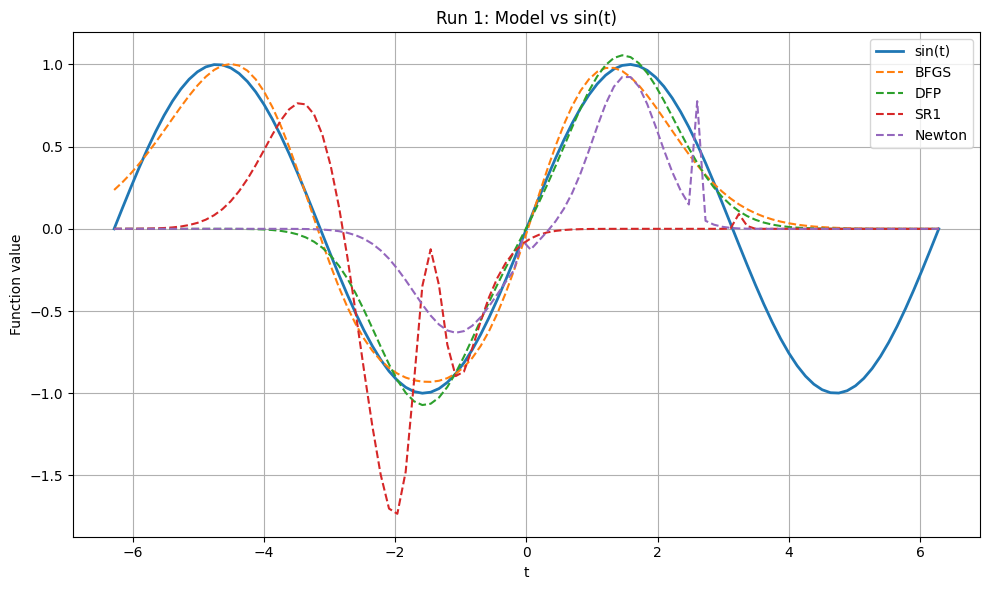


=== Run 2 (scale = 0.4) ===

BFGS
Final ||x̄ - x*||: 4.754080
ℓₖ = 0.999999, qₖ = 0.210345 → Superlinear
Runtime: 2.5867s

DFP
Final ||x̄ - x*||: 4.556814
ℓₖ = 1.060639, qₖ = 0.246873 → Diverging or very slow
Runtime: 0.4659s

SR1
Final ||x̄ - x*||: 4.196963
ℓₖ = 1.004175, qₖ = 0.240261 → Diverging or very slow
Runtime: 2.0686s
Hessian ill-conditioned at iteration 14 (cond = 1.93e+19).

Newton
Final ||x̄ - x*||: 62.376463
ℓₖ = 16.099888, qₖ = 4.155516 → Diverging or very slow
Runtime: 0.6539s


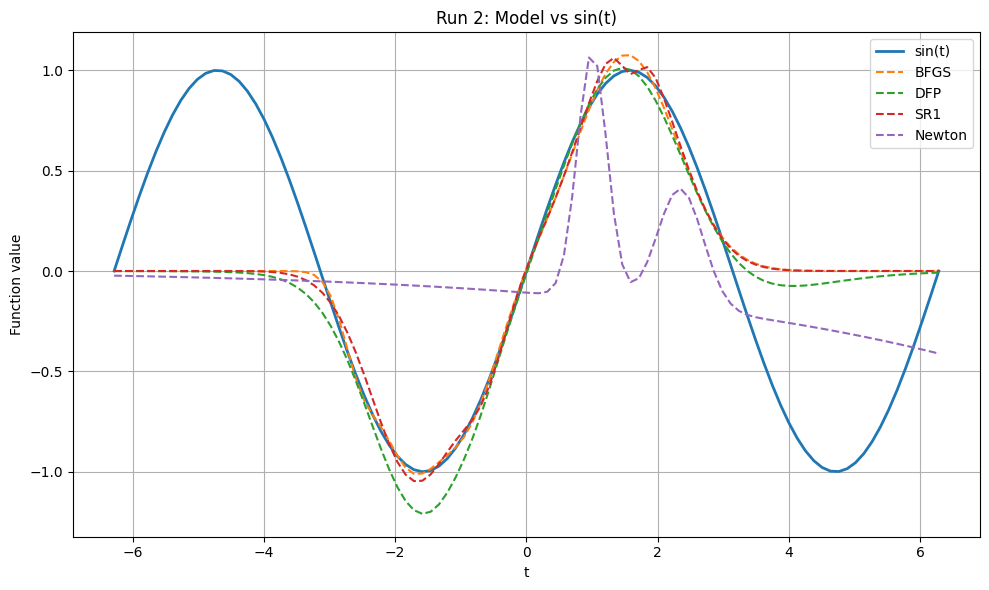


=== Run 3 (scale = 0.6) ===

BFGS
Final ||x̄ - x*||: 16.309317
ℓₖ = 1.047905, qₖ = 0.067330 → Diverging or very slow
Runtime: 3.3574s

DFP
Final ||x̄ - x*||: 4.521493
ℓₖ = 1.062116, qₖ = 0.249495 → Diverging or very slow
Runtime: 0.5318s

SR1
Final ||x̄ - x*||: 4.722680
ℓₖ = 0.940321, qₖ = 0.187225 → Superlinear
Runtime: 2.1022s

Newton
Final ||x̄ - x*||: 4.339381
ℓₖ = 1.001530, qₖ = 0.231153 → Diverging or very slow
Runtime: 5.4687s


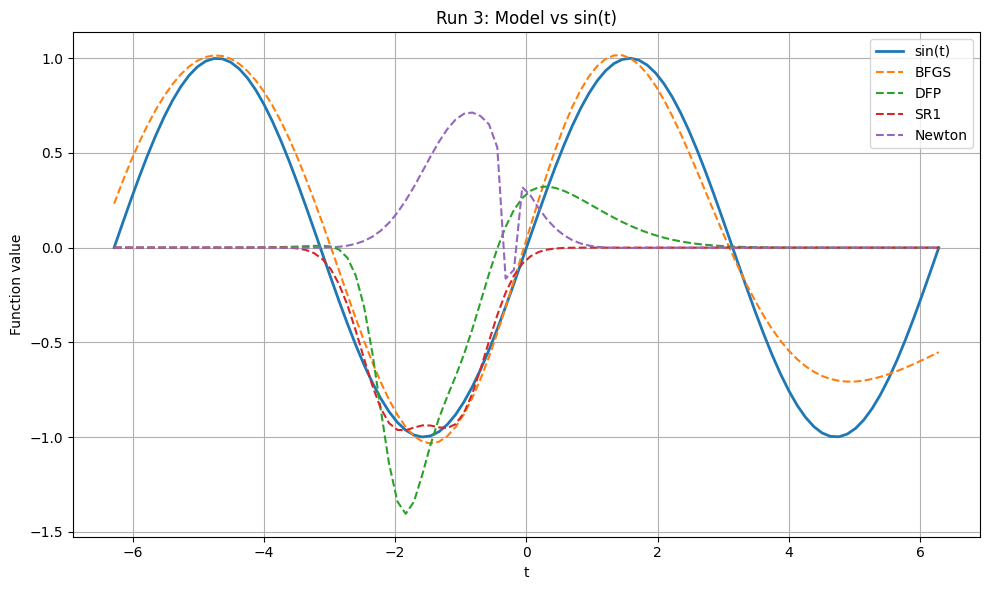


=== Run 4 (scale = 0.8) ===

BFGS
Final ||x̄ - x*||: 10.219942
ℓₖ = 0.998019, qₖ = 0.097461 → Superlinear
Runtime: 3.3167s

DFP
Final ||x̄ - x*||: 17.320707
ℓₖ = 1.025513, qₖ = 0.060718 → Diverging or very slow
Runtime: 3.3083s

SR1
Final ||x̄ - x*||: 7.878348
ℓₖ = 1.020311, qₖ = 0.132139 → Diverging or very slow
Runtime: 2.0569s
Hessian ill-conditioned at iteration 66 (cond = 2.27e+14).

Newton
Final ||x̄ - x*||: 114.567893
ℓₖ = 9.339548, qₖ = 0.761358 → Diverging or very slow
Runtime: 3.3051s


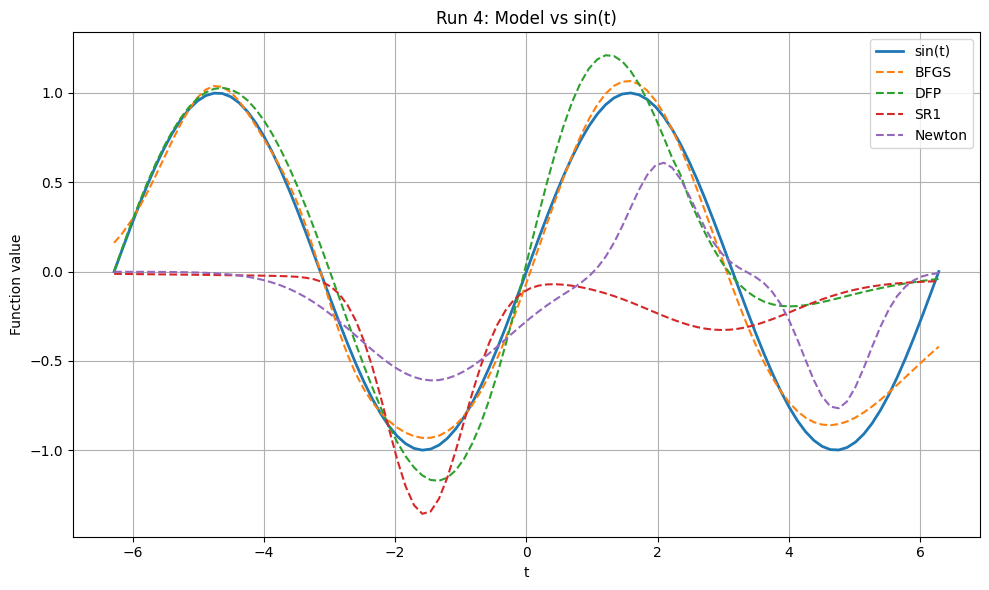


=== Run 5 (scale = 1.0) ===

BFGS
Final ||x̄ - x*||: 5.201732
ℓₖ = 1.000008, qₖ = 0.192247 → Diverging or very slow
Runtime: 3.4876s

DFP
Final ||x̄ - x*||: 4.210629
ℓₖ = 1.005661, qₖ = 0.240191 → Diverging or very slow
Runtime: 1.1646s

SR1
Final ||x̄ - x*||: 4.838842
ℓₖ = 1.005082, qₖ = 0.208767 → Diverging or very slow
Runtime: 2.0391s

Newton
Final ||x̄ - x*||: 10.136393
ℓₖ = 1.004088, qₖ = 0.099463 → Diverging or very slow
Runtime: 4.8923s


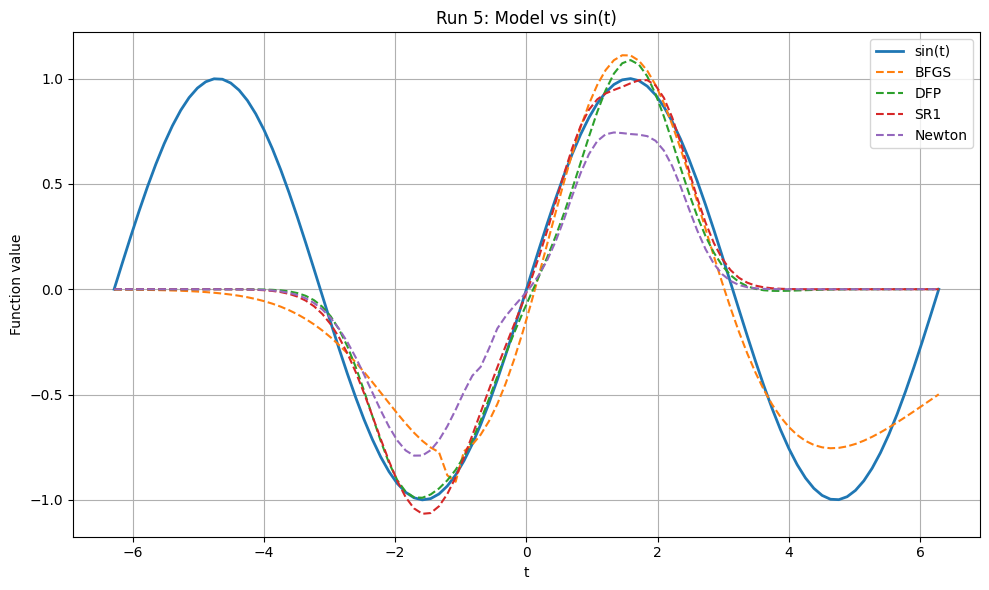


=== Run 6 (scale = 1.2) ===

BFGS
Final ||x̄ - x*||: 11.725433
ℓₖ = 1.010147, qₖ = 0.087024 → Diverging or very slow
Runtime: 3.2313s

DFP
Final ||x̄ - x*||: 4.880527
ℓₖ = 1.000081, qₖ = 0.204929 → Diverging or very slow
Runtime: 3.2151s

SR1
Final ||x̄ - x*||: 8.568445
ℓₖ = 1.110398, qₖ = 0.143898 → Diverging or very slow
Runtime: 2.0490s

Newton
Final ||x̄ - x*||: 2.442077
ℓₖ = 0.999888, qₖ = 0.409396 → Superlinear
Runtime: 5.4425s


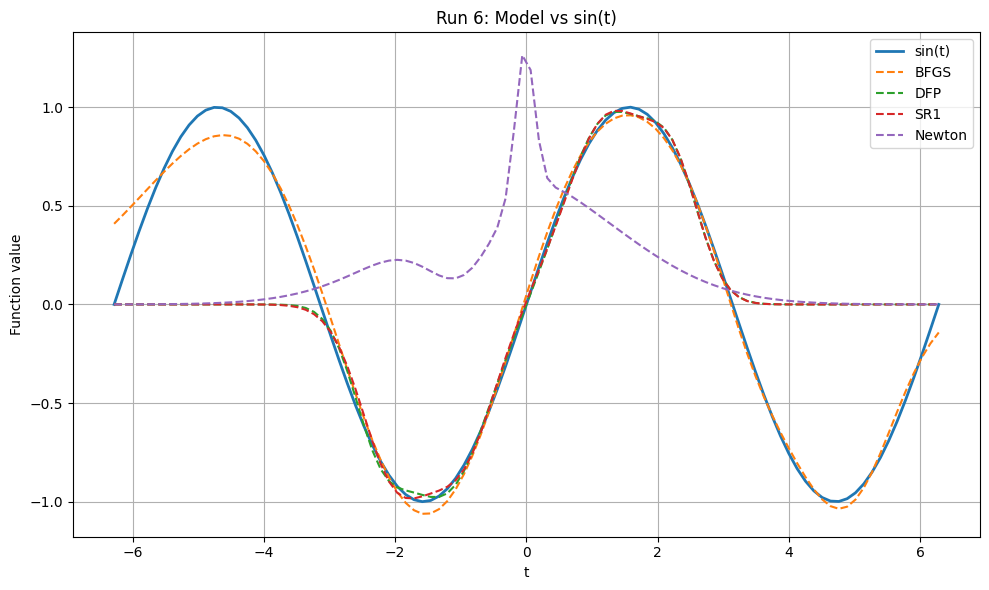


=== Run 7 (scale = 1.4) ===

BFGS
Final ||x̄ - x*||: 292.861088
ℓₖ = 1.033903, qₖ = 0.003650 → Quadratic
Runtime: 3.2213s

DFP
Final ||x̄ - x*||: 13.872251
ℓₖ = 1.025274, qₖ = 0.075776 → Diverging or very slow
Runtime: 0.9464s

SR1
Final ||x̄ - x*||: 2.946292
ℓₖ = 0.964079, qₖ = 0.315464 → Superlinear
Runtime: 2.0227s
Hessian ill-conditioned at iteration 2 (cond = 3.10e+13).

Newton
Final ||x̄ - x*||: 33.781613
ℓₖ = 3.542021, qₖ = 0.371383 → Diverging or very slow
Runtime: 0.1010s


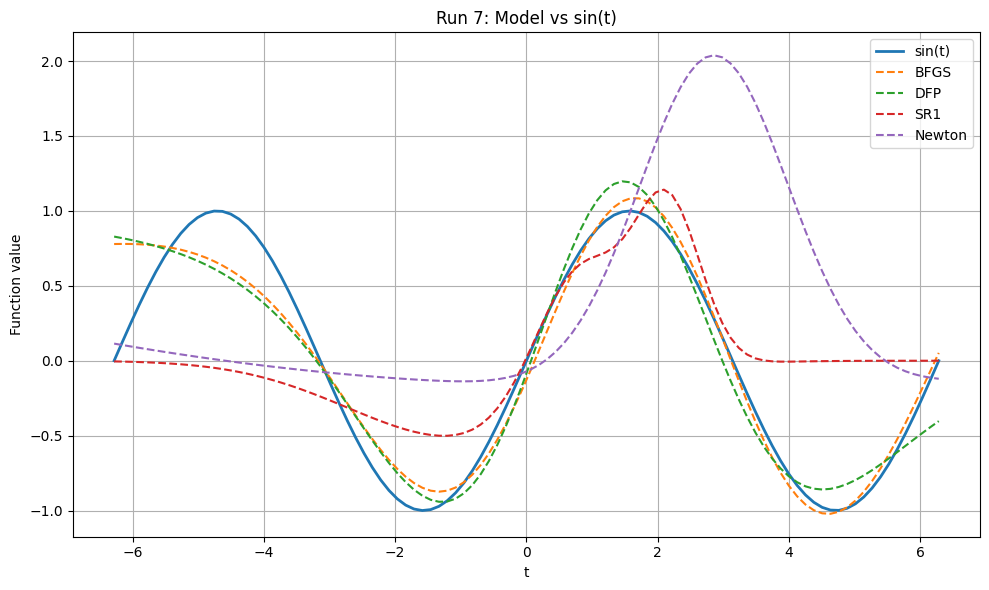


=== Run 8 (scale = 1.6) ===

BFGS
Final ||x̄ - x*||: 10.547771
ℓₖ = 0.990605, qₖ = 0.093034 → Superlinear
Runtime: 3.2437s

DFP
Final ||x̄ - x*||: 4.816632
ℓₖ = 1.006577, qₖ = 0.210354 → Diverging or very slow
Runtime: 1.1091s

SR1
Final ||x̄ - x*||: 4.882567
ℓₖ = 1.000000, qₖ = 0.204810 → Diverging or very slow
Runtime: 1.3924s
Hessian ill-conditioned at iteration 6 (cond = 3.34e+12).

Newton
Final ||x̄ - x*||: 3.488200
ℓₖ = 0.837306, qₖ = 0.200987 → Superlinear
Runtime: 0.2894s


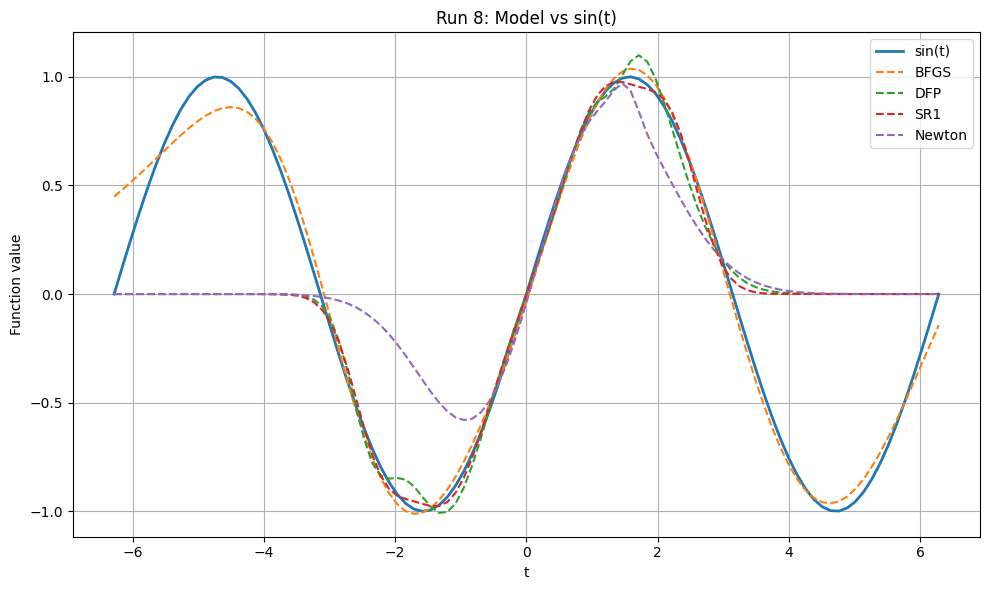


=== Run 9 (scale = 1.8) ===

BFGS
Final ||x̄ - x*||: 51.314574
ℓₖ = 1.001215, qₖ = 0.019535 → Diverging or very slow
Runtime: 3.2265s

DFP
Final ||x̄ - x*||: 14.537752
ℓₖ = 1.003544, qₖ = 0.069275 → Diverging or very slow
Runtime: 3.1779s

SR1
Final ||x̄ - x*||: 7.819336
ℓₖ = 1.073331, qₖ = 0.147332 → Diverging or very slow
Runtime: 2.0121s

Newton
Final ||x̄ - x*||: 6.126213
ℓₖ = 0.999777, qₖ = 0.163160 → Superlinear
Runtime: 5.5401s


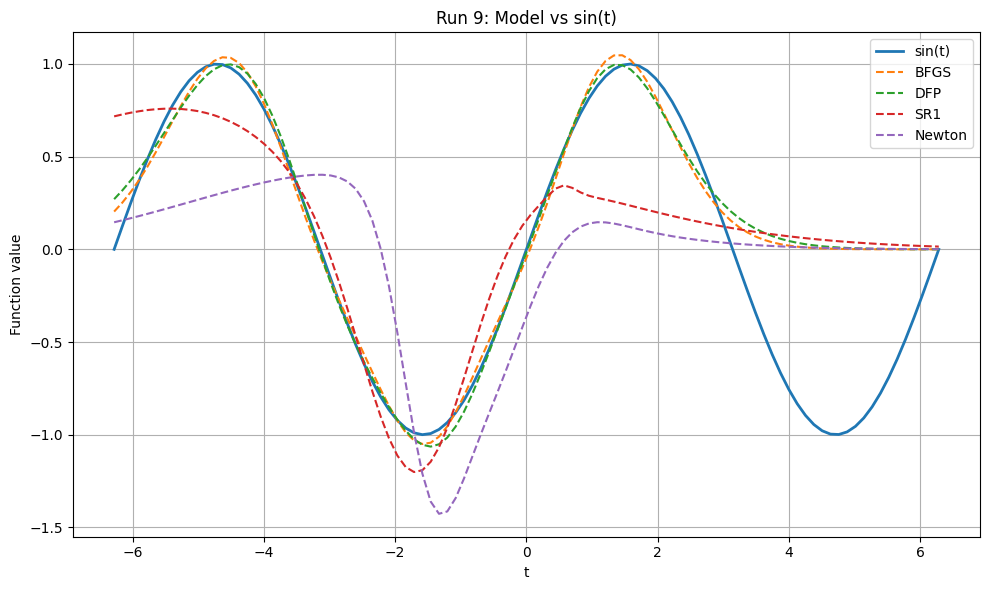


=== Run 10 (scale = 2.0) ===

BFGS
Final ||x̄ - x*||: 10.233024
ℓₖ = 1.004530, qₖ = 0.098610 → Diverging or very slow
Runtime: 3.2176s

DFP
Final ||x̄ - x*||: 7.564791
ℓₖ = 1.000289, qₖ = 0.132268 → Diverging or very slow
Runtime: 3.1991s

SR1
Final ||x̄ - x*||: 5.064326
ℓₖ = 1.016846, qₖ = 0.204169 → Diverging or very slow
Runtime: 2.0196s

Newton
Final ||x̄ - x*||: 6.277744
ℓₖ = 0.998642, qₖ = 0.158861 → Superlinear
Runtime: 4.9713s


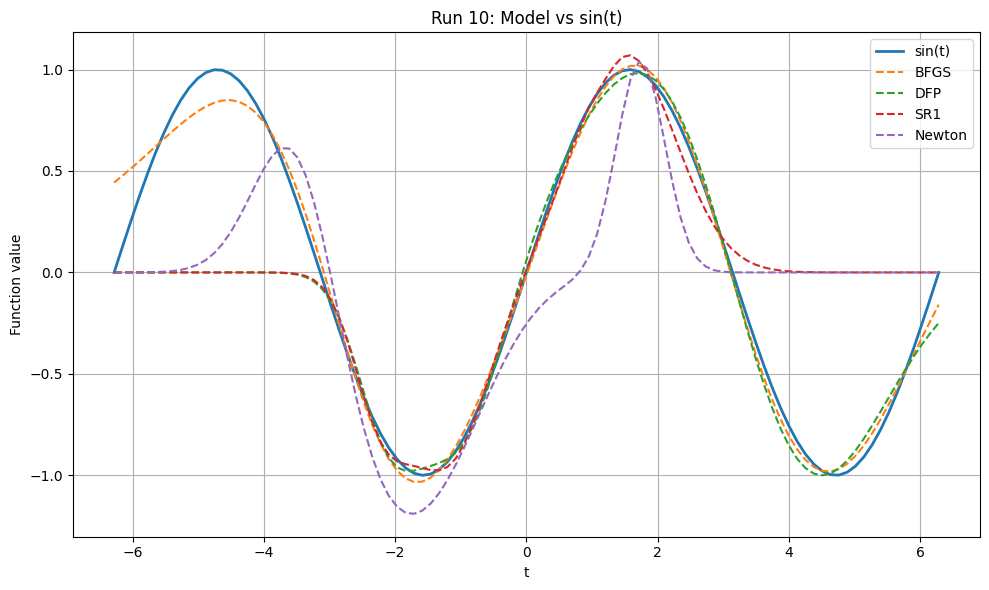


=== Run 11 (scale = 2.2) ===

BFGS
Final ||x̄ - x*||: 15.913834
ℓₖ = 1.000670, qₖ = 0.062923 → Diverging or very slow
Runtime: 3.2215s

DFP
Final ||x̄ - x*||: 3.573038
ℓₖ = 1.003752, qₖ = 0.281978 → Diverging or very slow
Runtime: 3.2166s

SR1
Final ||x̄ - x*||: 3.724985
ℓₖ = 0.998621, qₖ = 0.267718 → Superlinear
Runtime: 2.0468s
Hessian ill-conditioned at iteration 3 (cond = 6.25e+20).

Newton
Final ||x̄ - x*||: 4.590061
ℓₖ = 0.984589, qₖ = 0.211199 → Superlinear
Runtime: 0.1416s


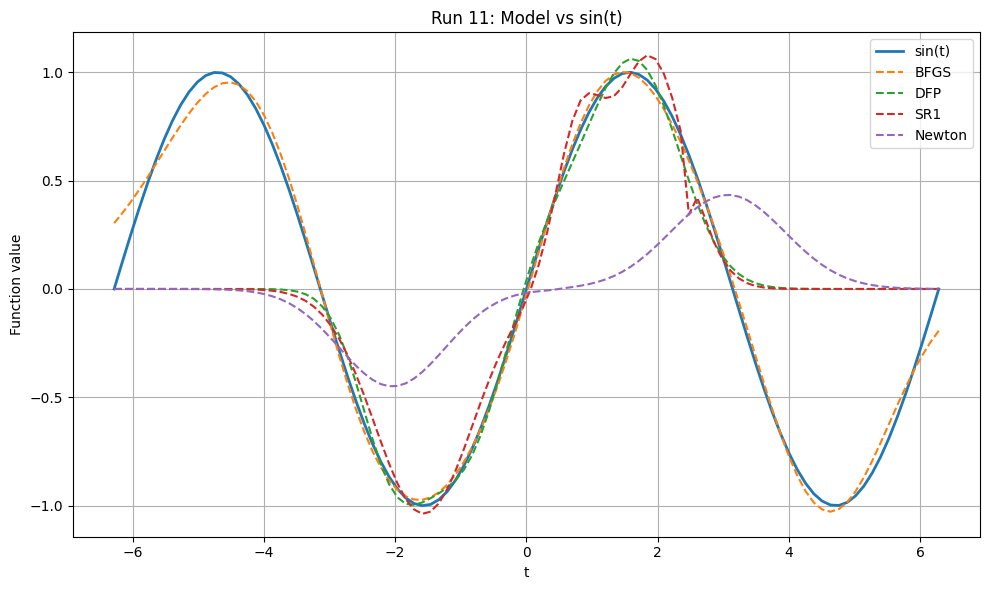


=== Run 12 (scale = 2.4) ===

BFGS
Final ||x̄ - x*||: 5286.357934
ℓₖ = 0.988072, qₖ = 0.000185 → Quadratic
Runtime: 3.3991s

DFP
Final ||x̄ - x*||: 22.291888
ℓₖ = 1.003468, qₖ = 0.045171 → Diverging or very slow
Runtime: 1.2923s

SR1
Final ||x̄ - x*||: 19.777051
ℓₖ = 1.025254, qₖ = 0.053150 → Diverging or very slow
Runtime: 2.0554s
Hessian ill-conditioned at iteration 36 (cond = 3.10e+20).

Newton
Final ||x̄ - x*||: 120.676149
ℓₖ = 4.456581, qₖ = 0.164582 → Diverging or very slow
Runtime: 1.7051s


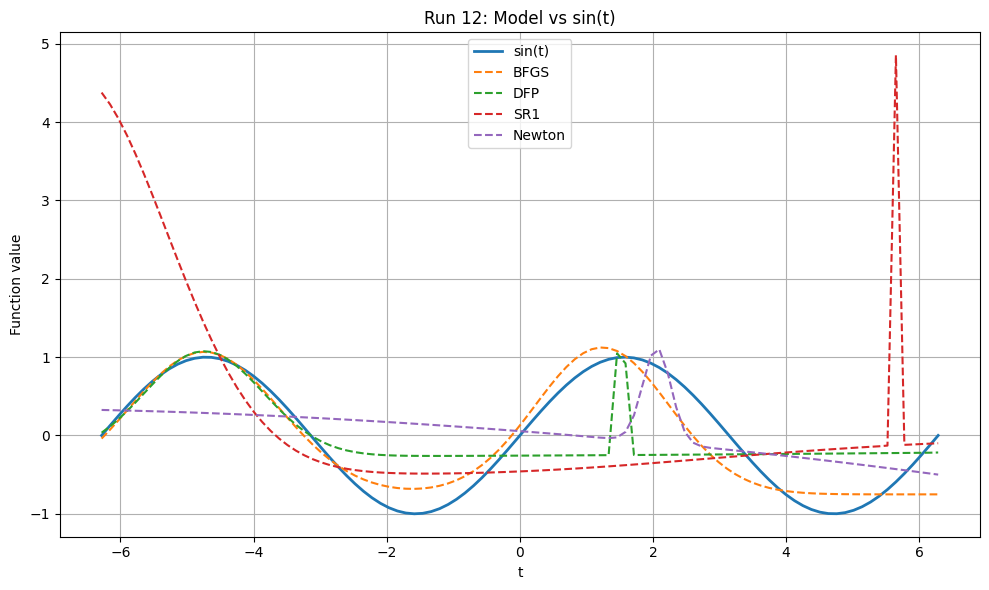


=== Run 13 (scale = 2.6) ===

BFGS
Final ||x̄ - x*||: 10.219109
ℓₖ = 1.004364, qₖ = 0.098712 → Diverging or very slow
Runtime: 3.2269s

DFP
Final ||x̄ - x*||: 11.797655
ℓₖ = 1.006094, qₖ = 0.085799 → Diverging or very slow
Runtime: 3.1904s

SR1
Final ||x̄ - x*||: 8.406582
ℓₖ = 0.927340, qₖ = 0.102296 → Superlinear
Runtime: 2.0805s
Hessian ill-conditioned at iteration 2 (cond = 3.69e+21).

Newton
Final ||x̄ - x*||: 734.559062
ℓₖ = 74.412701, qₖ = 7.538196 → Diverging or very slow
Runtime: 0.0984s


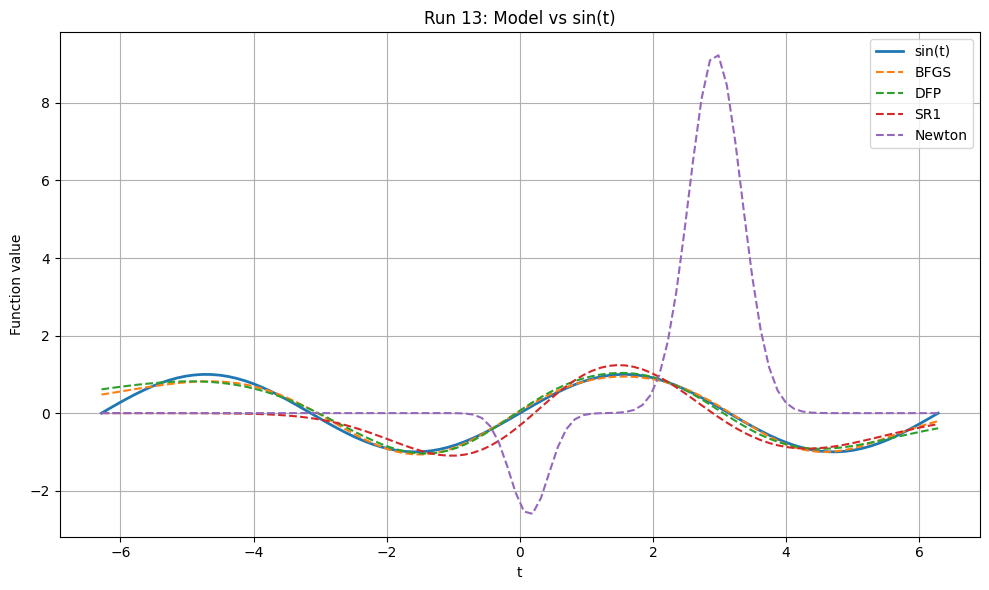


=== Run 14 (scale = 2.8) ===

BFGS
Final ||x̄ - x*||: 12.534479
ℓₖ = 0.999295, qₖ = 0.079667 → Superlinear
Runtime: 3.2243s

DFP
Final ||x̄ - x*||: 14.608941
ℓₖ = 0.998888, qₖ = 0.068299 → Superlinear
Runtime: 0.9218s

SR1
Final ||x̄ - x*||: 7.596206
ℓₖ = 1.004787, qₖ = 0.132908 → Diverging or very slow
Runtime: 2.0763s
Hessian ill-conditioned at iteration 2 (cond = 1.98e+18).

Newton
Final ||x̄ - x*||: 25608.008201
ℓₖ = 287.850002, qₖ = 3.235614 → Diverging or very slow
Runtime: 0.1005s


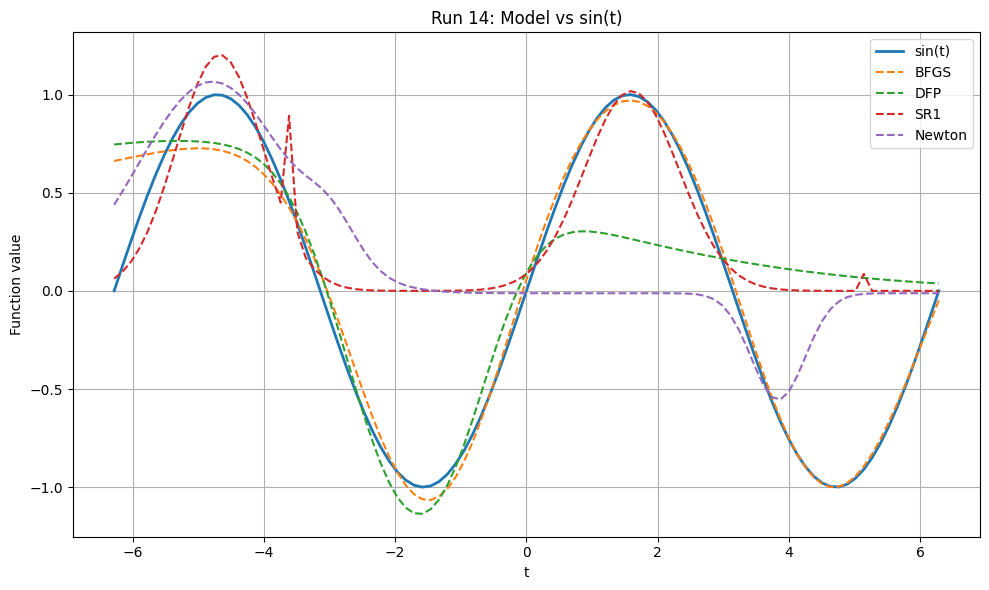


=== Run 15 (scale = 3.0) ===

BFGS
Final ||x̄ - x*||: 18.860115
ℓₖ = 1.001226, qₖ = 0.053152 → Diverging or very slow
Runtime: 3.2908s

DFP
Final ||x̄ - x*||: 11.899918
ℓₖ = 0.978703, qₖ = 0.080493 → Superlinear
Runtime: 0.5078s

SR1
Final ||x̄ - x*||: 8.593989
ℓₖ = 1.022692, qₖ = 0.121701 → Diverging or very slow
Runtime: 2.0264s
Hessian ill-conditioned at iteration 4 (cond = 3.52e+13).

Newton
Final ||x̄ - x*||: 70.939804
ℓₖ = 5.955940, qₖ = 0.500047 → Diverging or very slow
Runtime: 0.1899s


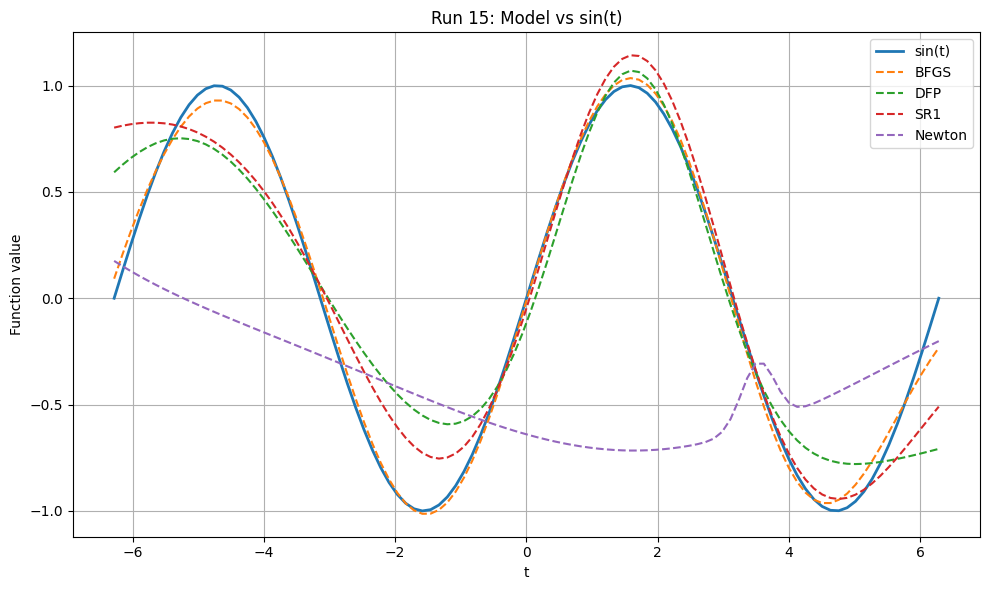


=== Method Summary ===

Method: BFGS
Successful convergence to x*: 0/15
Rates of convergence distribution:
  Quadratic: 2
  Superlinear: 5
  Linear: 0
  Diverging or very slow: 8
Average runtime: 3.2412 seconds

Method: DFP
Successful convergence to x*: 0/15
Rates of convergence distribution:
  Quadratic: 0
  Superlinear: 2
  Linear: 0
  Diverging or very slow: 13
Average runtime: 1.9635 seconds

Method: SR1
Successful convergence to x*: 0/15
Rates of convergence distribution:
  Quadratic: 0
  Superlinear: 4
  Linear: 0
  Diverging or very slow: 11
Average runtime: 2.0074 seconds

Method: Newton
Successful convergence to x*: 0/15
Rates of convergence distribution:
  Quadratic: 0
  Superlinear: 6
  Linear: 0
  Diverging or very slow: 9
Average runtime: 2.2249 seconds


In [18]:
methods = [bfgs_method, dfp_method, sr1_method, newton_method]
method_names = ["BFGS", "DFP", "SR1", "Newton"]
scales = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]
num_runs = len(scales)
evaluate_all_runs(objective, phi, x0, methods, method_names, a, b, num_runs, scales)